In [16]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.optimize import root_scalar, curve_fit
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

# 44.04 Milhões de habitantes em SP
SP_POP = 44.04e6

In [2]:
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.head()

,Data,Vacinados,Delta
0,2021-01-19 11:16:00,3908,NaN
1,2021-01-20 14:14:00,17318,13410.0
2,2021-01-20 15:11:00,18409,1091.0
3,2021-01-20 15:19:00,18729,320.0
4,2021-01-20 15:24:00,18834,105.0


In [3]:
# Eliminando nulos e valores onde a diferença do anterior é menor que 0
# por que as vezes o site do vacinometro reporta valores errados
data = data.dropna()
data = data.drop(data.query("Delta <= 0").index)
data.sample(10)

,Data,Vacinados,Delta
178,2021-01-22 01:12:00,55164,6.0
191,2021-01-22 08:19:00,57013,94.0
182,2021-01-22 01:47:00,55195,5.0
159,2021-01-21 19:43:00,52973,48.0
338,2021-01-23 15:40:00,120451,77.0
326,2021-01-23 14:25:00,119314,139.0
464,2021-01-24 06:40:00,124697,6.0
590,2021-01-25 00:55:00,130956,1.0
425,2021-01-24 01:50:00,124560,5.0
217,2021-01-22 13:27:00,75857,253.0


In [4]:
# Vamos remover todas as entradas cuja a diferença
# da anterior (coluna delta) estiver acima de 3 desvios padrões da média (pelo mesmo motivo)
std = data.Delta.std()
mean = data.Delta.mean()
data = data.drop(data.query("Delta > @mean+2.5*@std").index)

In [5]:
# Para cada entrada, calcula em qual hora do ano ela foi computada (24*(dia_do_ano-1) + hora_do_dia)
# Dia do ano - 1 por que o primeiro dia começa na hora 0
data["HourOfYear"] = 24*(data.Data.dt.dayofyear-1) + data.Data.dt.hour
# Agrupa registros q aconteceram dentro da mesma hora e escolhe o maior valor
vacinados_hora = data.groupby("HourOfYear").max()["Vacinados"]

x, y = vacinados_hora.index, vacinados_hora

In [6]:
# Sem o -1 porque vou ignorar o primeiro dia
hora_inicial = data.Data.dt.dayofyear.min()*24
# Gerando as linhas q indicam o começo de cada dia
vlines = [hora_inicial + 24 * i for i in range(data.Data.dt.dayofyear.max()-data.Data.dt.dayofyear.min())]

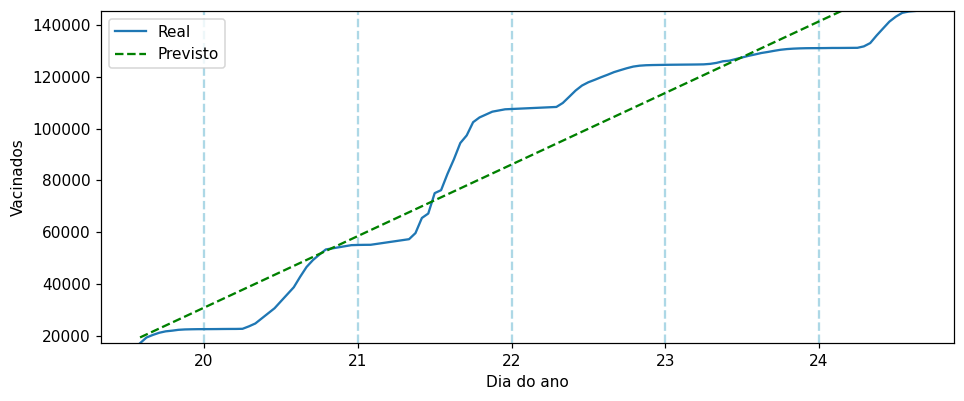

In [7]:
fig, ax = plt.subplots(figsize = (10,4), dpi=110)

# Encontrando um polinômio de grau 1 q aproxima a curva
m, b = np.polyfit(vacinados_hora.index, vacinados_hora, 1)

def modelo_linear(x, m=m, b=b):
    return m * x + b

ax.plot(x, y, label="Real")
ax.plot(x, modelo_linear(x), color='g', linestyle='--', label="Previsto")
ax.set(xlabel="Dia do ano",
       ylabel="Vacinados",
       ylim=(y.min(), y.max()), 
       xticks=vlines,
       xticklabels=np.array(vlines)//24)
ax.legend()

ax.vlines(vlines, ymin=vacinados_hora.min(), ymax=vacinados_hora.max(), color='lightblue', linestyle='--');

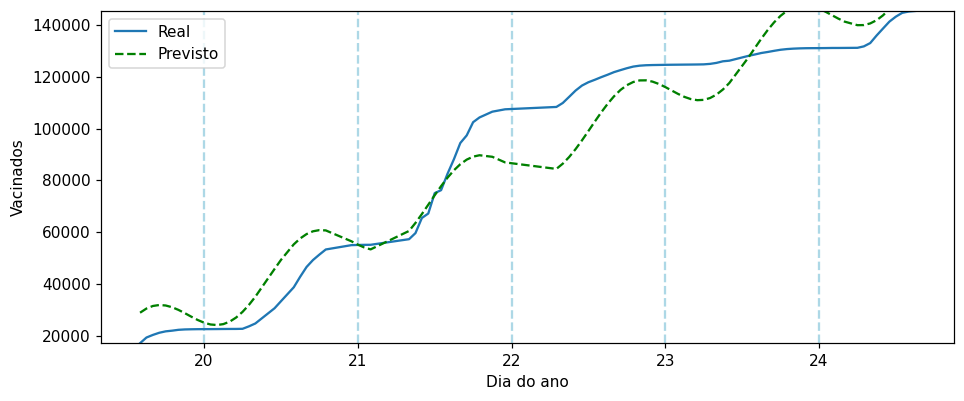

In [8]:
fig, ax = plt.subplots(figsize = (10,4), dpi=110)

# Vamos tentar incorporar o elemento periódico manualmente 
# (esse valores são encontrados usando tentativa e error)
amplitude = 10000
freq = 0.25
fase = np.pi

# Adicionamos um termos periódico (seno) à nossa reta
def modelo_periodico(x, amplitude, freq, fase, m=m, b=b):
    return modelo_linear(x, m, b) + amplitude*np.sin(freq*x + fase)

ax.plot(vacinados_hora.index, vacinados_hora, label="Real")
ax.plot(x, modelo_periodico(x, amplitude, freq,fase), color='g', linestyle='--', label="Previsto")
ax.set(xlabel="Dia do ano",
       ylabel="Vacinados",
       ylim=(y.min(), y.max()),
       xticks=vlines,
       xticklabels=np.array(vlines)//24)
ax.legend()

ax.vlines(vlines, ymin=y.min()-10, ymax=y.max()+10, color='lightblue', linestyle='--');

In [9]:
# Encontrando a raíz do modelo linear para 90% da população vacinada
sol = root_scalar(lambda x:modelo_linear(x) - (0.9*SP_POP), x0=0, x1=24)
# Dividimos por 24 pra saber qual dia (dia 0 = 1/1/2021)
sol.root/24

1457.1338520038705

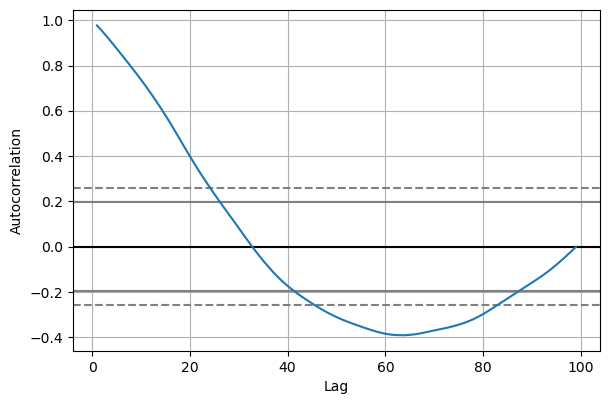

In [29]:
fig,ax = plt.subplots(figsize=(6,4), dpi=100)
fig.tight_layout()
autocorrelation_plot(vacinados_hora, ax);

/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


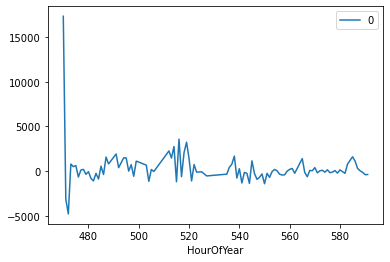

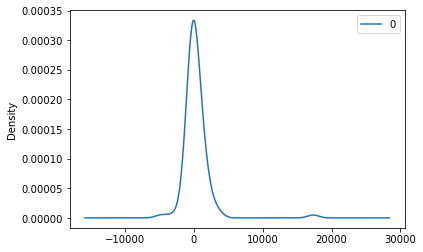

                  0
count     99.000000
mean     292.061850
std     2059.703120
min    -4793.251588
25%     -374.227449
50%       -6.346726
75%      689.597186
max    17318.000000


In [31]:
model = ARIMA(vacinados_hora, order=(20,1,0))
model_fit = model.fit()
# summary of fit model
#print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [11]:
# A Soma das diferenças em cada hora 
delta_hora = data.groupby("HourOfYear").sum()["Delta"]
x, delta_y = delta_hora.index, delta_hora

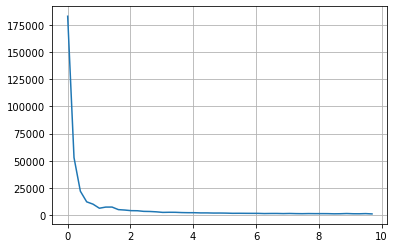

In [12]:
# Number of sample points
N = len(delta_y)
# sample spacing
T = 1.0 / 20
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()